# K-means clustering of untagged intent tweets

- SpACY + POS tagging
- w2v 
- elbow method for choosing
- word cloud to visualize topics
- 

In [210]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer

from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk import word_tokenize

import matplotlib.pyplot as plt

### Load data and pre-process

In [211]:
import re
import contractions

In [212]:
# First, import/export the positive and neutral-sentiment tweets
data_path = "../data/"
raw_data = pd.read_csv(data_path + "Tweets.csv")

In [213]:
pos_tweets = raw_data[raw_data['airline_sentiment'] != 'negative']

In [214]:
pos_tweets.head(3)

tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   
1            NaN                        0.0  Virgin America   
2            NaN                        NaN  Virgin America   

  airline_sentiment_gold        name negativereason_gold  retweet_count  \
0                    NaN     cairdin                 NaN              0   
1                    NaN    jnardino                 NaN              0   
2                    NaN  yvonnalynn                 NaN              0   

                                                text tweet_coord  \
0                @VirginAmerica What @dhepburn said.         NaN   
1  @VirginAmerica plus you've added commercials t...         NaN   
2  @VirginAmerica I didn't today... Must mean I n...         NaN   

               tweet_created tweet_location               user_timezone  
0  2015-02-24 11:35:52 -0800            NaN  Eastern Time (US & Canada)  
1  2015-02-24 11:15:59 -0800            NaN  Pacific Time (US & Canada)  
2  2015-02-24 11:15:48 -0800      Lets Play  Central Time (US & Canada)

In [215]:
intent = pos_tweets.copy()

In [216]:
import re
#import contractions

def clean_data(x):
    x = x.lower() # convert to all lower case
    x = re.sub('http\S+', '', x) # remove URLs
    x = re.sub('<.*?>', '', x) # remove HTML tags
    x = contractions.fix(x) # expand contractions
    x = re.sub('[^a-z]', ' ', x) # remove non-alphabetic characters
    x = re.sub('\s\s+', ' ', x) # remove extra whitespace
    return x

In [217]:
stopwords_eng = set(stopwords.words('english'))
intent['airline'] = intent['airline'].apply(clean_data)
airline = [word for word in intent.airline.unique()]
airline = [re.sub('\s+', '', x) for x in airline]
airline_long = [word+'air' for word in intent.airline.unique()]
airline_long = [re.sub('\s+', '', x) for x in airline_long]

intent.text = intent.text.apply(clean_data)

stopwords_eng = set(stopwords.words('english'))
stopwords_eng.update(intent.airline.unique())
stopwords_eng.update(airline)
stopwords_eng.update(['jetblue'])

stopwords_eng.update(airline_long)

In [218]:
def remove_stopwords(text):
    
    clean = ' '.join([word for word in text.split(' ') if word not in stopwords_eng])
    return clean

In [219]:
print(intent.text[0])
print(remove_stopwords((intent.text[0])))

 virginamerica what dhepburn said 
 dhepburn said 


In [220]:
intent.text = intent.text.apply(remove_stopwords)

## clustering pipeline: tf-idf + SVD + word cloud

In [221]:
#!pip install wordcloud

In [222]:
from sklearn.decomposition import TruncatedSVD

from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score, silhouette_samples

from wordcloud import WordCloud

In [223]:
# To find K of K-means using elbow method.
# Plot the loss vs k graph to find the elbow point

def findK(X, max_k=50):
    
    distortions = []
    inertias = []
    mapping1 = {}
    mapping2 = {}

    for k in range(2, max_k):
        kmeans = KMeans(n_clusters=k, max_iter=300, random_state=5).fit(X)
        
        distortions.append(sum(np.min(cdist(X, kmeans.cluster_centers_,
                                    'euclidean'), axis=1)) / X.shape[0])
        
        # Inertia: Sum of distances of samples to their closest cluster center
        inertias.append(kmeans.inertia_)

        mapping1[k] = sum(np.min(cdist(X, kmeans.cluster_centers_,
                                       'euclidean'), axis=1)) / X.shape[0]
        mapping2[k] = kmeans.inertia_


    fig, ax = plt.subplots(2, 1)
    ax[0].plot(list(mapping1.keys()), list(mapping1.values()))
    ax[0].set(title='Elbow method using distortions',
              xlabel="Number of clusters",
             ylabel="Loss Value")

    ax[1].plot(list(mapping2.keys()), list(mapping2.values()))
    ax[1].set(title='Elbow method using inertias',
              xlabel="Number of clusters",
             ylabel="Loss Value")
    plt.show()

In [224]:
# takes the term frequencies as a dictionary per each cluster and prints to top n terms from list
def print_top_terms(term_weights, n_terms):

    for i, counts in term_weights.items():
        print(f"Cluster {i}: ", end="")
        sorted_counts = sorted(counts.items(), key=lambda x:x[1], reverse=True)[0:n_terms]
        for term in sorted_counts:
            print(term[0], end=" ")
        print()

In [225]:
def generate_frequencies(X, in_X_tfidf, k, in_word_positions, in_model):

    # Clustering
    in_y_pred = in_model.fit_predict(X)
    in_cluster_ids = set(in_y_pred)
    silhouette_avg = silhouette_score(X, in_y_pred)
    print("For n_clusters =", k, "The average silhouette_score is :", silhouette_avg)
    

    # Number of words with highest tfidf score to display
    top_count = 100
    
    cluster_frequencies = {}

    for in_cluster_id in in_cluster_ids:
        # compute the total tfidf for each term in the cluster
        in_tfidf = in_X_tfidf[in_y_pred == in_cluster_id]
        # numpy.matrix
        tfidf_sum = np.sum(in_tfidf, axis=0)
        # numpy.array of shape (1, X.shape[1])
        tfidf_sum = np.asarray(tfidf_sum).reshape(-1)
        top_indices = tfidf_sum.argsort()[-top_count:]
        term_weights = {in_word_positions[in_idx]: tfidf_sum[in_idx] for in_idx in top_indices}
        cluster_frequencies[in_cluster_id] = term_weights
        
    return cluster_frequencies

In [226]:
### Adopted from https://www.kaggle.com/code/albeffe/text-clustering-tfidf-pca-beginner-tutorial
# modified to: accept model parameters and return all word frequencies per cluster

# splitting above into two functions
def cluster_and_score(X, k, in_model):
    ''' Performs k-means clustering using provided model,
        prints the average silhoutte score and score for each cluster
        returns the cluster labels and centroids.
    '''
    
    # Clustering
    in_y_pred = in_model.fit_predict(X)
    silhouette_avg = silhouette_score(X, in_y_pred)
    print("For n_clusters =", k, "The average silhouette_score is :", silhouette_avg)

    sample_silhouette_values = silhouette_samples(X, in_model.labels_)
    print(f"Silhouette values:")
    silhouette_values = []
    for i in range(k):
        cluster_silhouette_values = sample_silhouette_values[in_model.labels_ == i]
        silhouette_values.append(
            (
                i,
                cluster_silhouette_values.shape[0],
                cluster_silhouette_values.mean(),
                cluster_silhouette_values.min(),
                cluster_silhouette_values.max(),
            )
        )
    silhouette_values = sorted(
        silhouette_values, key=lambda tup: tup[2], reverse=True
    )
    for s in silhouette_values:
        print(
            f"    Cluster {s[0]}: Size:{s[1]} | Avg:{s[2]:.2f} | Min:{s[3]:.2f} | Max: {s[4]:.2f}"
        )

    # todo: add silhouette score per cluster
    
    return in_y_pred, in_model.cluster_centers_

def generate_word_frequencies_tfidf(in_y_pred, in_X_tfidf, in_word_positions, top_count=100):
    
    in_cluster_ids = set(in_y_pred)
    cluster_frequencies = {}

    for in_cluster_id in in_cluster_ids:
        # compute the total tfidf for each term in the cluster
        in_tfidf = in_X_tfidf[in_y_pred == in_cluster_id]
        # numpy.matrix
        tfidf_sum = np.sum(in_tfidf, axis=0)
        # numpy.array of shape (1, X.shape[1])
        tfidf_sum = np.asarray(tfidf_sum).reshape(-1)
        top_indices = tfidf_sum.argsort()[-top_count:]
        term_weights = {in_word_positions[in_idx]: tfidf_sum[in_idx] for in_idx in top_indices}
        cluster_frequencies[in_cluster_id] = term_weights
        
    return cluster_frequencies

# def generate_word_frequencies_w2v(in_y_pred, in_X_w2v, ____(defining_word_pos), top_count=100):
    
    
#     kmeans_clustering = KMeans(n_clusters = num_clusters, init='k-means++');
#     idx = kmeans_clustering.fit_predict(word_vectors);
    
#     return kmeans_clustering.cluster_centers_, idx;

In [227]:
def generate_wordclouds(frequencies, filename):
    
    for in_cluster_id, term_weights in frequencies.items():
        
        wc = WordCloud(width=1200, height=800, background_color="white")
        wordcloud = wc.generate_from_frequencies(term_weights)
        fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis("off")
        fig.suptitle(f"Cluster {in_cluster_id}")
        
        fig.savefig(filename.split('.png')[0]+'_cluster={}.png'.format(in_cluster_id))
        plt.show()

## Finding best model based on: sensibility of word cloud groups, cluster silhouette values

Parameters to explore:
- pre-processing options
- optimal K
- word embedding
- dimensionality reduction choice (n_components, SVD/UMAP/etc)

In [82]:
# Using tf-idf to vectorize documents by BoW
vectorizer = TfidfVectorizer(min_df=5, max_df=.5)
X_tfidf = vectorizer.fit_transform(intent.text)

word_positions = {v: k for k, v in vectorizer.vocabulary_.items()}

In [206]:
X_tfidf.shape

(5462, 1311)

### Baseline: tf-idf vector

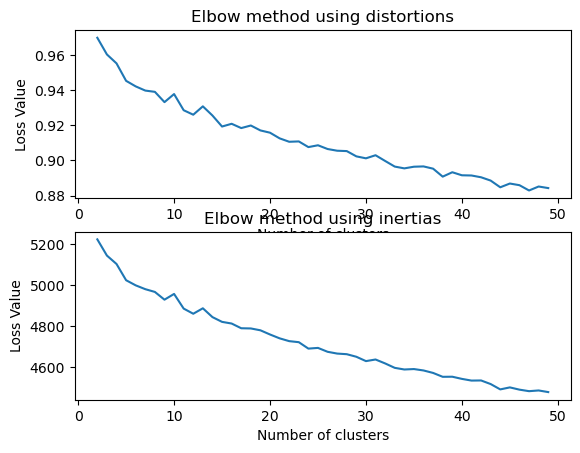

In [208]:
findK(X_tfidf.toarray())

In [239]:
# todo: put all into a scoring/testing function -- takes in different models, X_values
k = 5
modelname = 'kmeans_tfidf'

kmeans = KMeans(n_clusters=k, max_iter=300, random_state=5)

y_pred, centroid = cluster_and_score(X_tfidf.toarray(), k, kmeans)
freqs = generate_word_frequencies_tfidf(y_pred, X_tfidf, word_positions)
print_top_terms(freqs, 10)
out_filename = '../figures/wordcloud_model={}_k={}_n_components={}.png'.format(
                                                                        modelname,
                                                                        kmeans.n_clusters,
                                                                        X_svd.shape[1]
                                                                        )

For n_clusters = 5 The average silhouette_score is : 0.03117494865179597
Silhouette values:
    Cluster 2: Size:117 | Avg:0.51 | Min:0.21 | Max: 0.67
    Cluster 1: Size:239 | Avg:0.29 | Min:0.10 | Max: 0.52
    Cluster 0: Size:246 | Avg:0.24 | Min:0.09 | Max: 0.46
    Cluster 3: Size:875 | Avg:0.01 | Min:-0.10 | Max: 0.12
    Cluster 4: Size:3985 | Avg:-0.01 | Min:-0.18 | Max: 0.02
Cluster 0: thanks much sent awesome got dm great ok help made 
Cluster 1: thank much great response ok okay help sent awesome appreciate 
Cluster 2: fleek fleet rt lol lmao wow stop oh happened real 
Cluster 3: flight thanks cancelled great get tomorrow time need booking help 
Cluster 4: thanks get please dm love would flights help thank service 


### Applying SVD to feature vector

In [228]:
# use svd to reduce dimensionality
svd = TruncatedSVD(n_components=30, random_state=42)
X_svd = svd.fit_transform(X_tfidf)
print(f"Total variance explained: {np.sum(svd.explained_variance_ratio_):.2f}")

Total variance explained: 0.20


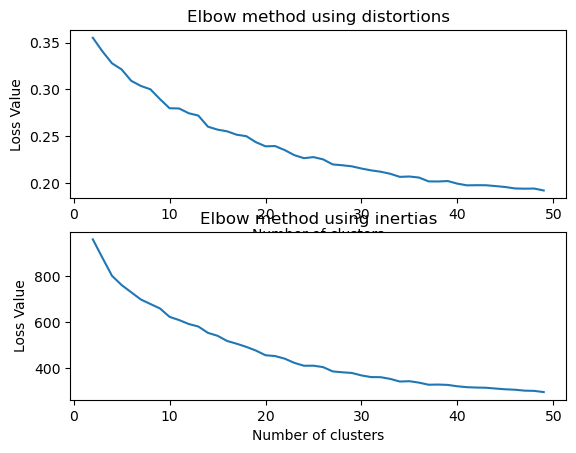

In [229]:
findK(X_svd)

Choosing cluster = 4 for n_components = 30 -- seems to be a dip/inflection point right after k=5 in distortions, and between 4-6 for inertias

In [231]:
# todo: put all into a scoring/testing function -- takes in different models, X_values
k = 4
modelname = 'kmeans_no_airlines'

kmeans = KMeans(n_clusters=k, max_iter=300, random_state=5)
y_pred, centroid = cluster_and_score(X_svd, k, kmeans)
freqs = generate_word_frequencies_tfidf(y_pred, X_tfidf, word_positions)
print_top_terms(freqs, 10)
out_filename = '../figures/wordcloud_model={}_k={}_n_components={}.png'.format(
                                                                        modelname,
                                                                        kmeans.n_clusters,
                                                                        X_svd.shape[1]
                                                                        )

For n_clusters = 4 The average silhouette_score is : 0.41418509694711503
Silhouette values:
    Cluster 3: Size:117 | Avg:0.74 | Min:0.25 | Max: 0.84
    Cluster 0: Size:4917 | Avg:0.42 | Min:-0.16 | Max: 0.58
    Cluster 2: Size:184 | Avg:0.27 | Min:-0.10 | Max: 0.58
    Cluster 1: Size:244 | Avg:0.26 | Min:-0.09 | Max: 0.56
Cluster 0: flight thanks get please great dm love would help flights 
Cluster 1: thank much great response ok okay help sent awesome appreciate 
Cluster 2: thanks much awesome sent ok made got update flight help 
Cluster 3: fleek fleet rt lol lmao wow stop oh happened real 


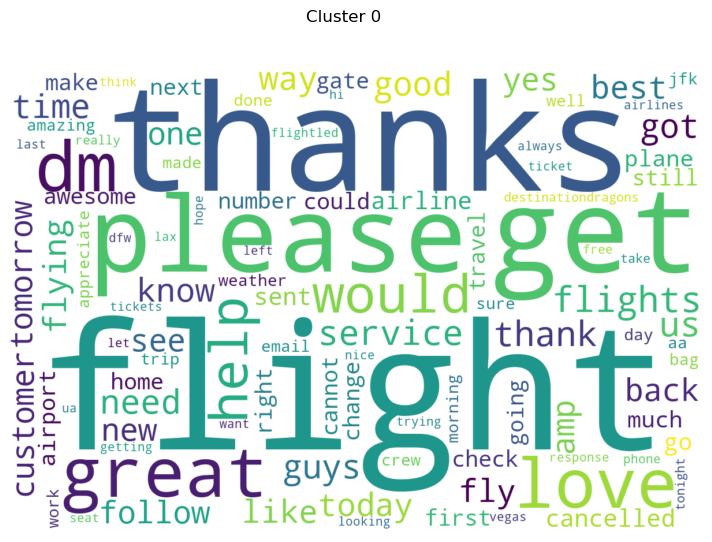

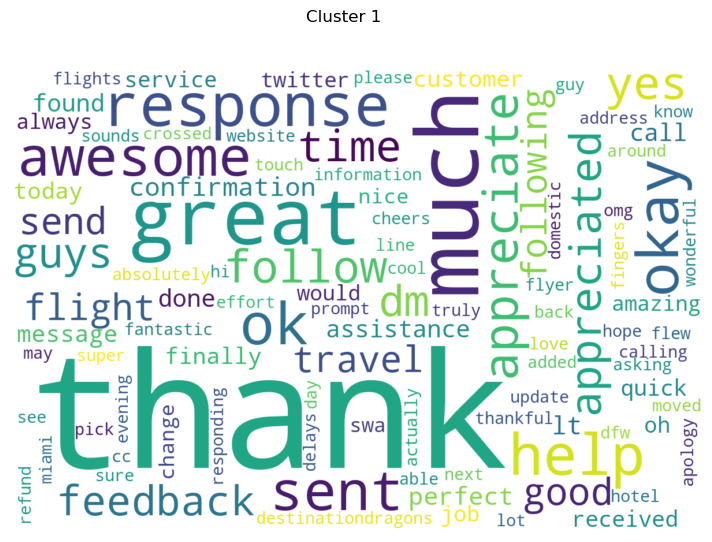

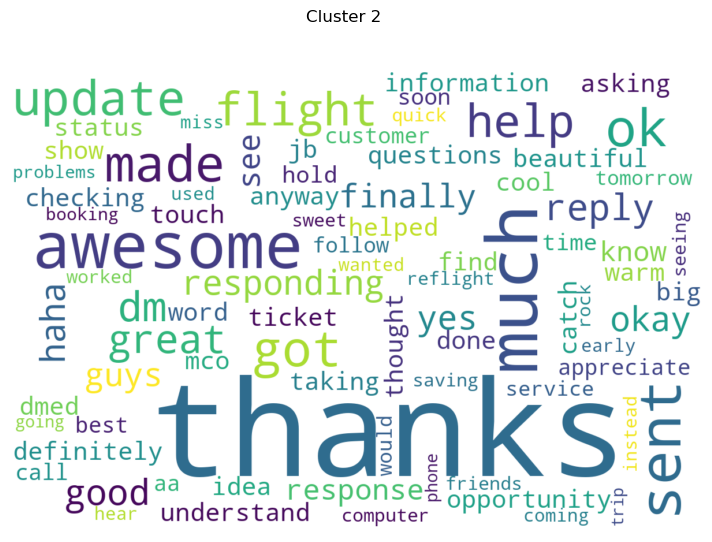

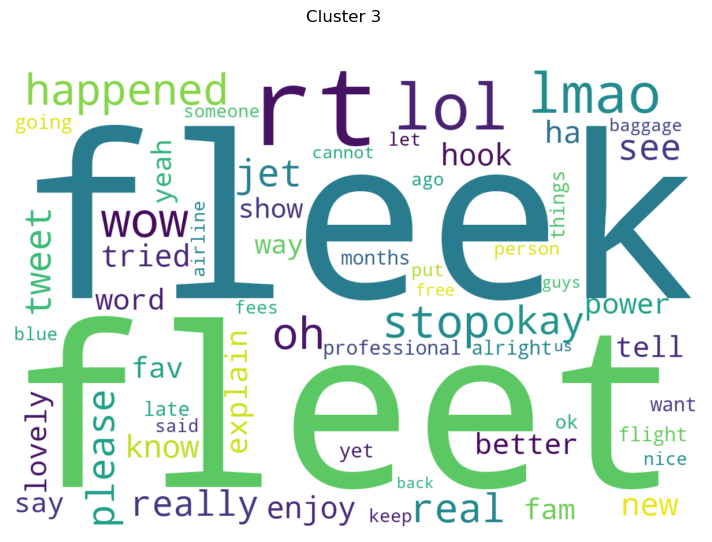

In [232]:
# I like that cluster 3 is a good example of funny tweets
out_filename = '../figures/wordcloud_model={}_k={}_n_components={}.png'.format(
                                                                        "small_kmeans_noairlines",
                                                                        kmeans.n_clusters,
                                                                        X_svd.shape[1]
                                                                        )
generate_wordclouds(freqs, out_filename)

In [233]:
# Using higher value for truncated SVD == keeping more of the words and increasing the explained variance

# use svd to reduce dimensionality
svd = TruncatedSVD(n_components=200, random_state=42)
X_svd = svd.fit_transform(X_tfidf)
print(f"Total variance explained: {np.sum(svd.explained_variance_ratio_):.2f}")

Total variance explained: 0.52


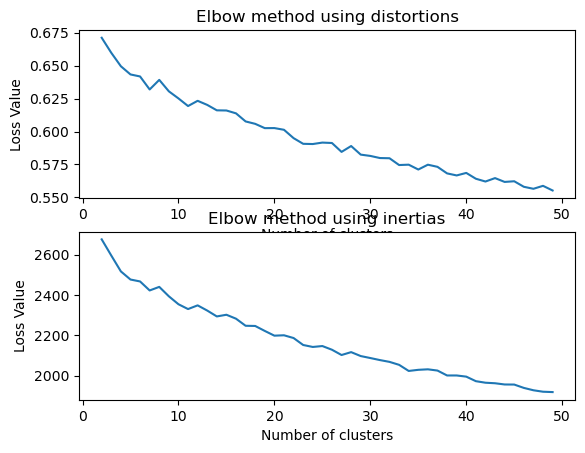

In [234]:
findK(X_svd)

Choosing cluster = 8 for n_components = 200 -- seems to be a dip/inflection point right after k=11

In [235]:
k = 4
modelname = 'kmeans_no_airlines'

kmeans = KMeans(n_clusters=k, max_iter=300, random_state=5)
y_pred, centroid = cluster_and_score(X_svd, k, kmeans)
freqs = generate_word_frequencies_tfidf(y_pred, X_tfidf, word_positions)
print_top_terms(freqs, 10)

For n_clusters = 4 The average silhouette_score is : 0.14567489948694892
Silhouette values:
    Cluster 0: Size:117 | Avg:0.54 | Min:0.18 | Max: 0.69
    Cluster 2: Size:237 | Avg:0.26 | Min:0.03 | Max: 0.52
    Cluster 3: Size:299 | Avg:0.13 | Min:-0.02 | Max: 0.40
    Cluster 1: Size:4809 | Avg:0.13 | Min:-0.20 | Max: 0.24
Cluster 0: fleek fleet rt lol lmao wow stop oh happened real 
Cluster 1: flight thanks get please love would help dm flights great 
Cluster 2: thank much great response ok okay help sent awesome follow 
Cluster 3: thanks much got sent great awesome flight dm ok good 


In [236]:
# todo: put all into a scoring/testing function -- takes in different models, X_values
k = 8
modelname = 'kmeans_no_airlines'

kmeans = KMeans(n_clusters=k, max_iter=300, random_state=5)
y_pred, centroid = cluster_and_score(X_svd, k, kmeans)
freqs = generate_word_frequencies_tfidf(y_pred, X_tfidf, word_positions)
print_top_terms(freqs, 10)

For n_clusters = 8 The average silhouette_score is : 0.08257282391591787
Silhouette values:
    Cluster 0: Size:117 | Avg:0.54 | Min:0.17 | Max: 0.69
    Cluster 3: Size:228 | Avg:0.27 | Min:0.03 | Max: 0.54
    Cluster 2: Size:197 | Avg:0.26 | Min:0.02 | Max: 0.53
    Cluster 5: Size:58 | Avg:0.11 | Min:0.03 | Max: 0.26
    Cluster 1: Size:48 | Avg:0.11 | Min:0.03 | Max: 0.28
    Cluster 6: Size:159 | Avg:0.09 | Min:-0.03 | Max: 0.25
    Cluster 4: Size:163 | Avg:0.06 | Min:-0.00 | Max: 0.18
    Cluster 7: Size:4492 | Avg:0.05 | Min:-0.20 | Max: 0.12
Cluster 0: fleek fleet rt lol lmao wow stop oh happened real 
Cluster 1: already thanks made flight get rr thank still trip like 
Cluster 2: thanks much awesome got ok great flight made update sent 
Cluster 3: thank much great response ok okay help awesome follow time 
Cluster 4: need help flight please get change cancelled reservation work possible 
Cluster 5: pass boarding companion tsa get pre please passbook thanks passes 
Cluster 6: 

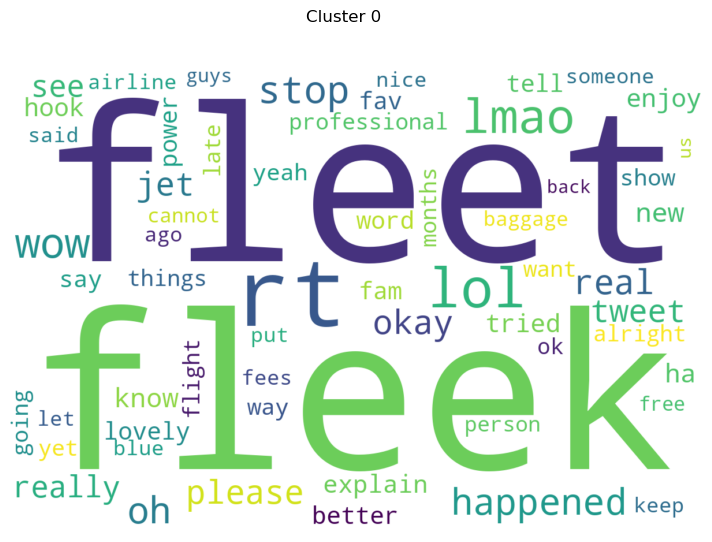

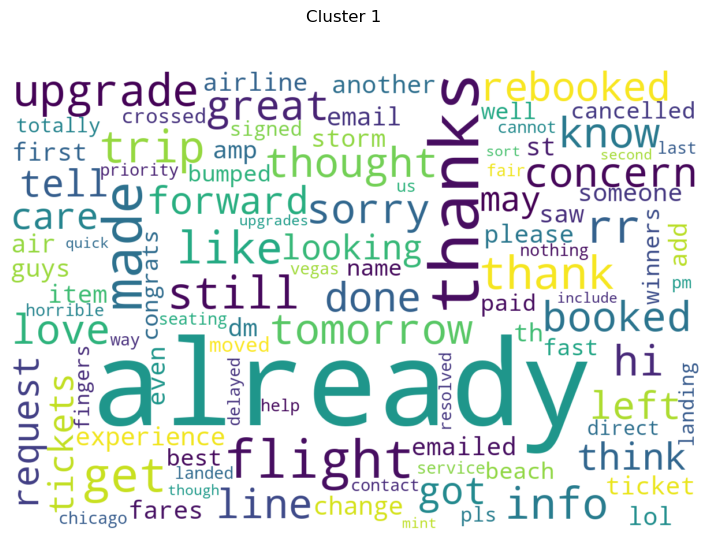

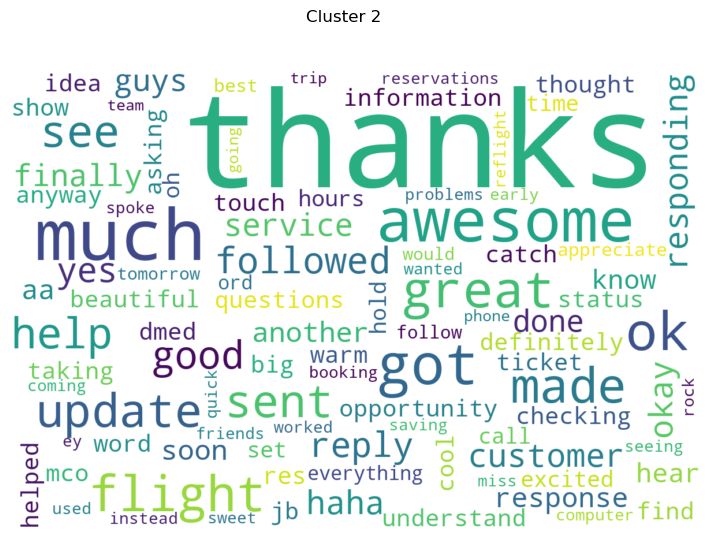

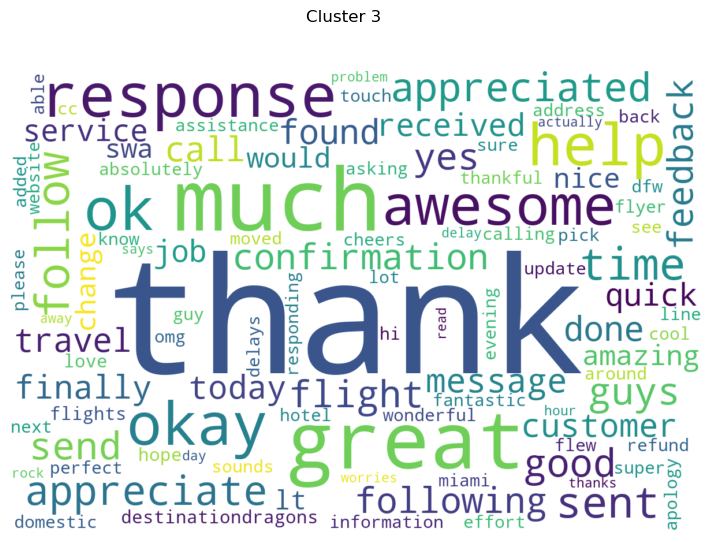

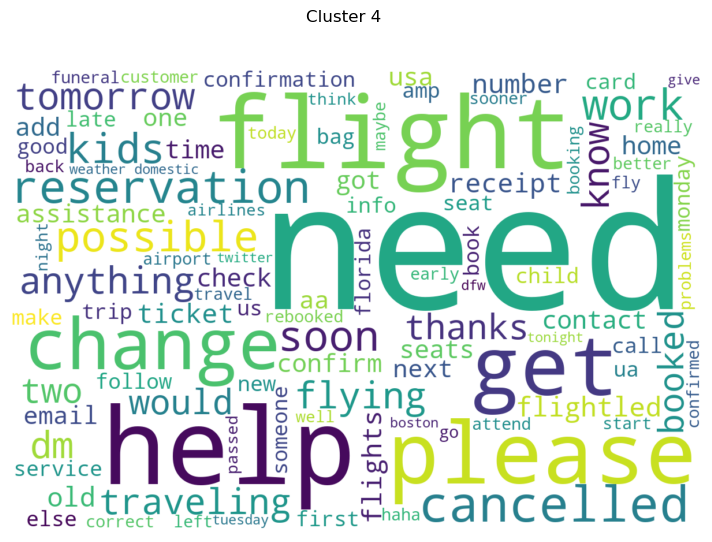

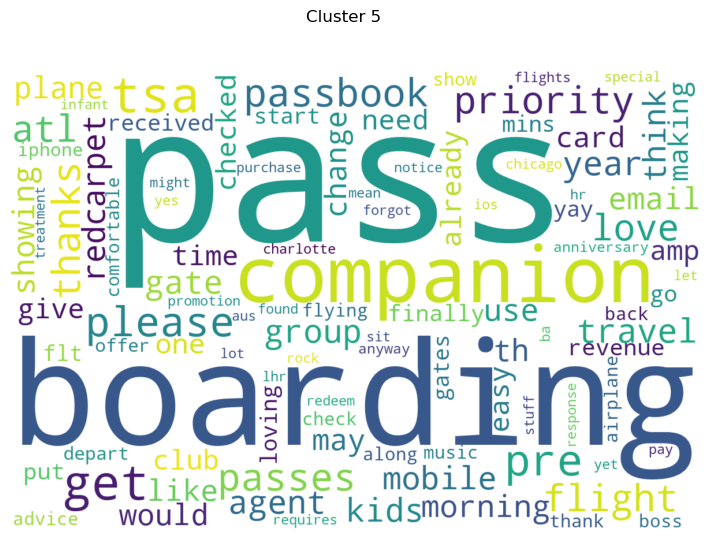

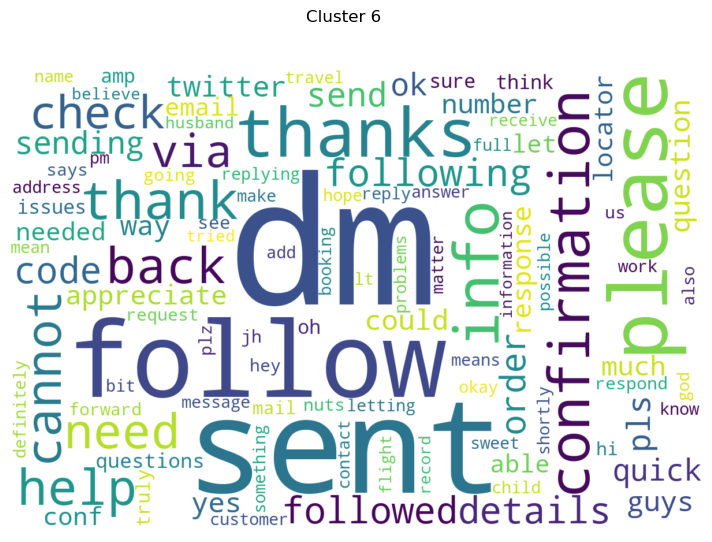

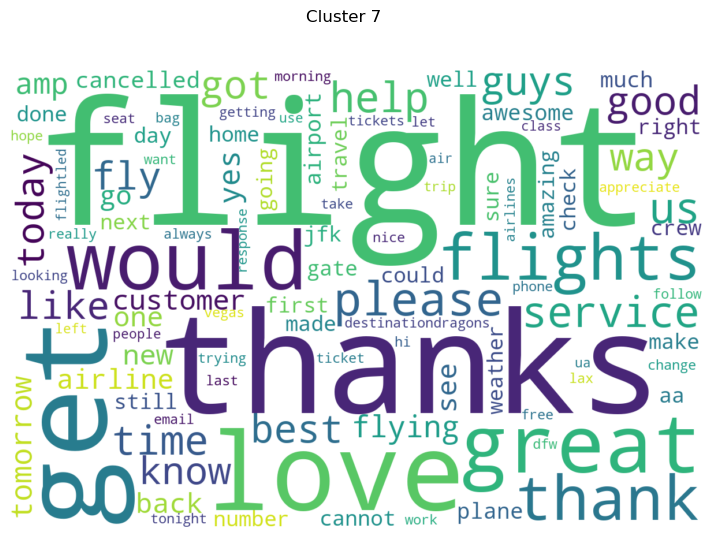

In [237]:
# these ones somewhate make sense == generating wordclouds
out_filename = '../figures/wordcloud_model={}_k={}_n_components={}.png'.format(
                                                                        'kmeans_no_airlines_thanks_categorized',
                                                                        kmeans.n_clusters,
                                                                        X_svd.shape[1]
                                                                        )
generate_wordclouds(freqs, out_filename)

### Description of 8 categories above:

- Cluster 0: Slang and fun twitter comments
- Cluster 1: Has to do with timing, booking, most people seem to be requesting help 
- Cluster 2: Thanking: mostly seems to be positive reviews of customer service
- Cluster 3: Thanking: mostly seems to be positive reviews of customer service, more associated with feedback of some kind
- Cluster 4: Requests: people with questions looking for help with booking, flight or reservation changes, wanting timely attention 
- Cluster 5: Passes, boarding, seems to be a combination of praise and requests 
- Cluster 6: People referencing or requesting correspondence, specifically electronically or through twitter
- Cluster 7: People generally talking about flights, mostly positively 

### Dev Zone: Generating wordclouds and top features

Using our best number of components for dimensionality reduction and k-value for clustering, let's look at the most representative words for describing each cluster

- [x] word cloud visualizations
- [x] most frequent set of words in each cluster
- [ ] (optional?) Clustering on cosine word similarity // maybe distance to centroid 
- [ ] optional / todo: all cluster silhouettes: gather + print silhouettes per cluster / generate graph??

In [ ]:
# todo: write function for all_cluster_silhouettes + print

In [85]:
# todo: put all into a scoring/testing function -- takes in different models, X_values
k = 6
modelname = 'kmeans_no_airlines'

kmeans = KMeans(n_clusters=k, max_iter=300, random_state=5)
freqs = generate_frequencies(X_svd, X_tfidf, k, word_positions, kmeans)
print_top_terms(freqs, 10)
out_filename = '../figures/wordcloud_model={}_k={}_n_components={}.png'.format(
                                                                        modelname,
                                                                        kmeans.n_clusters,
                                                                        X_svd.shape[1]
                                                                        )

For n_clusters = 6 The average silhouette_score is : 0.158059778267504
Cluster 0: thank much great response ok okay help awesome follow time 
Cluster 1: love get would flights please thank help service fly us 
Cluster 2: fleek fleet rt lol lmao wow stop oh happened real 
Cluster 3: flight thanks great get cancelled tomorrow time help got much 
Cluster 4: thanks got great help flight see good employees employee emergency 
Cluster 5: dm follow sent please thanks info need confirmation help thank 


In [94]:
y_pred, cent = cluster_and_score(X_svd, k, kmeans)
freqs = generate_word_frequencies_tfidf(y_pred, X_tfidf, word_positions)
print_top_terms(freqs, 10)

For n_clusters = 6 The average silhouette_score is : 0.158059778267504
Silhouette values:
    Cluster 4: Size:92 | Avg:0.76 | Min:0.04 | Max: 0.88
    Cluster 2: Size:117 | Avg:0.74 | Min:0.23 | Max: 0.84
    Cluster 0: Size:224 | Avg:0.28 | Min:-0.10 | Max: 0.58
    Cluster 1: Size:3515 | Avg:0.18 | Min:-0.13 | Max: 0.30
    Cluster 5: Size:158 | Avg:0.13 | Min:-0.14 | Max: 0.33
    Cluster 3: Size:1356 | Avg:0.00 | Min:-0.13 | Max: 0.18
Cluster 0: thank much great response ok okay help awesome follow time 
Cluster 1: love get would flights please thank help service fly us 
Cluster 2: fleek fleet rt lol lmao wow stop oh happened real 
Cluster 3: flight thanks great get cancelled tomorrow time help got much 
Cluster 4: thanks got great help flight see good employees employee emergency 
Cluster 5: dm follow sent please thanks info need confirmation help thank 


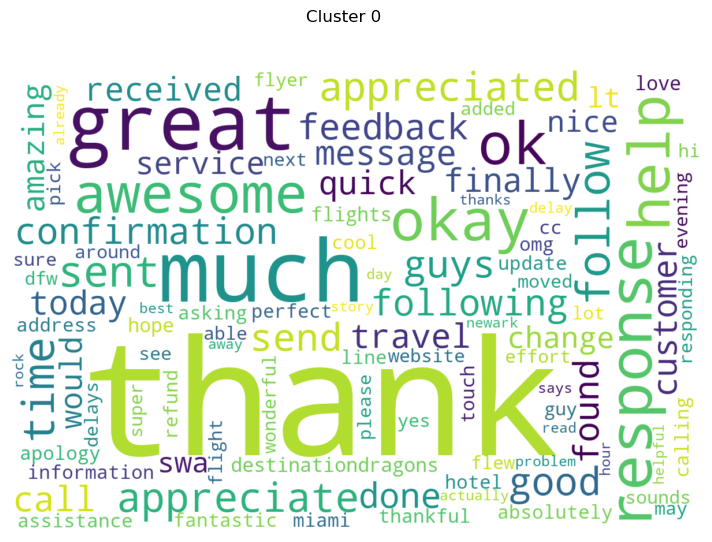

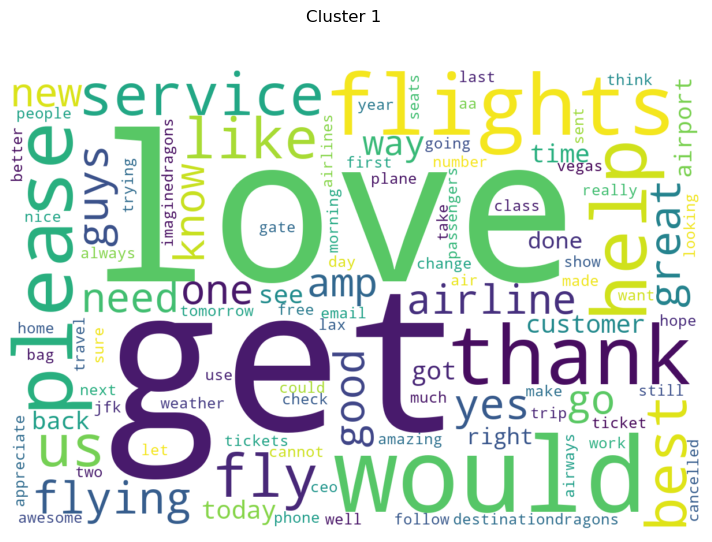

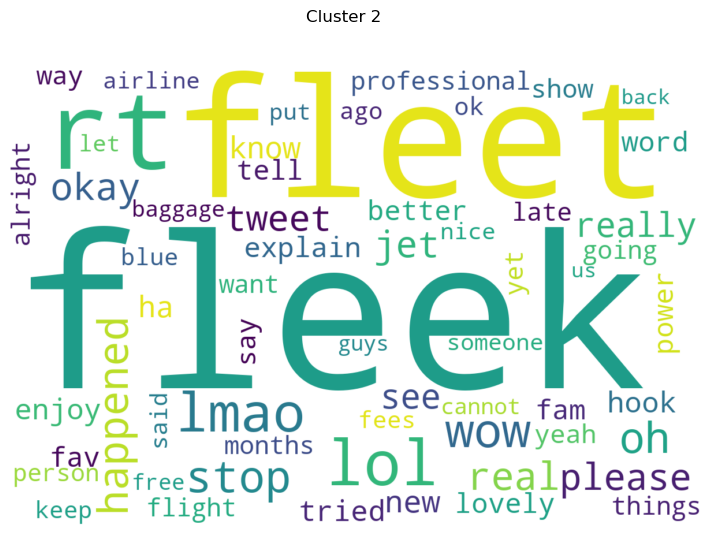

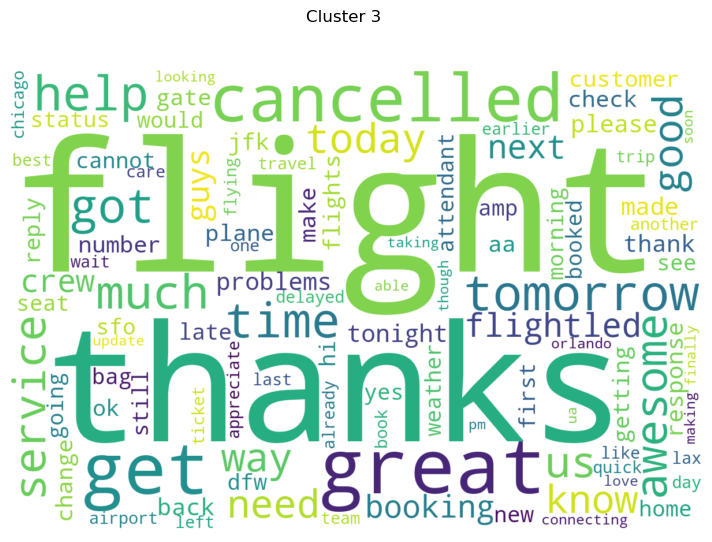

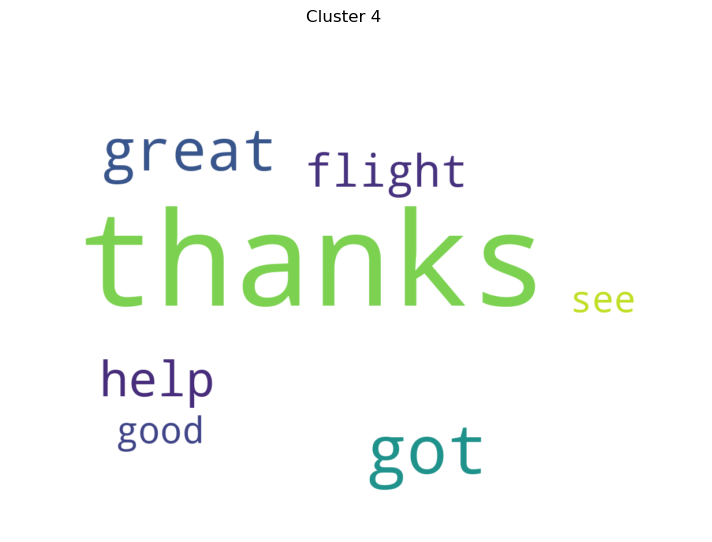

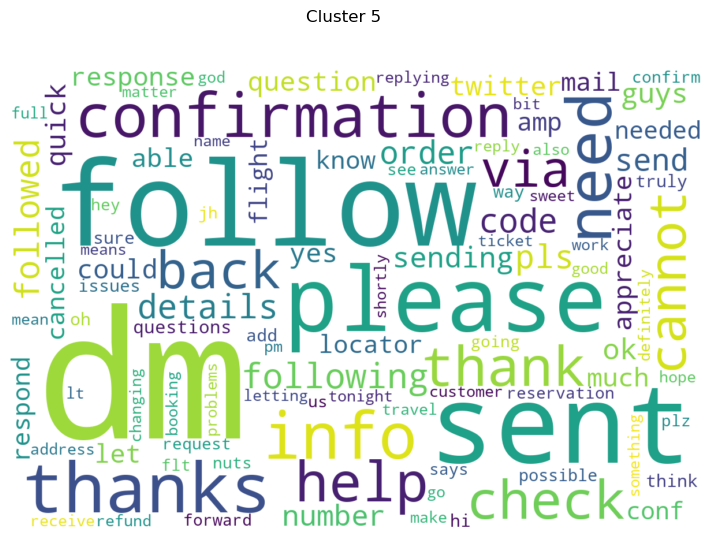

In [95]:
generate_wordclouds(freqs, out_filename)

## Trying: alternative word embeddings

- [x] w2v, repeat above 
       - can I use same functions?
- [x] spaCY + sense2vec
- [x] including POS tagging for documents

### word2vec

In [13]:
import gensim
from gensim import matutils

In [61]:
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')

In [64]:
embedding_size = 300

In [170]:
# generate averaged word2vec embeddings
# break up lines of the corpus into words
def generate_avg_w2v(reviews):
    
    w2v_encodings = np.empty([len(reviews), embedding_size])
    i = 0
    for _,line in reviews.items():
        if isinstance(line, str):
            w2v_sentence = [wv[word] for word in line.split() if word in wv.key_to_index.keys()]
            avg_sentence = np.average(np.asarray(w2v_sentence), axis=0)
            if np.isnan(avg_sentence).any():
                avg_sentence = np.zeros(embedding_size)
            w2v_encodings[i] = avg_sentence
            i+=1
    return w2v_encodings

In [165]:
intent_no_preproc.text = intent_no_preproc.text.apply(clean_data)

In [171]:
X_w2v = generate_avg_w2v(intent_no_preproc.text)

Two options for implementing w2v:

1. split everything by word-level and just try to generate clusters of words to generate clouds of similar topics / ideas
2. set some default vector size window, do some serious pre-processing of stopwords, then cluster by line
    --> to reverse-translate, break up the lines into windows of 300, and just
3. split tokens by word-level and train custom w2v model with this (i think dataset is too small)

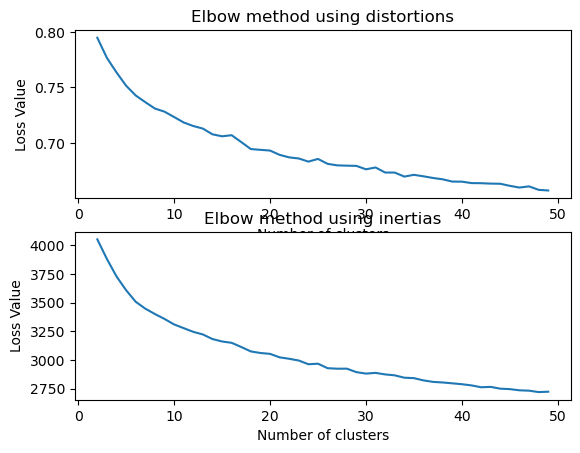

In [175]:
findK(X_w2v, max_k=50)

In [176]:
k = 7
modelname = 'kmeans_w2v'

kmeans = KMeans(n_clusters=k, max_iter=300, random_state=5)
y_pred, centroid = cluster_and_score(X_w2v, k, kmeans)
freqs = generate_word_frequencies_tfidf(y_pred, X_tfidf, word_positions)

print_top_terms(freqs, 10)

For n_clusters = 7 The average silhouette_score is : 0.04309580439933072
Silhouette values:
    Cluster 5: Size:64 | Avg:0.48 | Min:0.00 | Max: 0.71
    Cluster 2: Size:140 | Avg:0.25 | Min:-0.08 | Max: 0.50
    Cluster 4: Size:2419 | Avg:0.09 | Min:0.01 | Max: 0.18
    Cluster 6: Size:1191 | Avg:0.03 | Min:-0.03 | Max: 0.16
    Cluster 1: Size:205 | Avg:-0.02 | Min:-0.20 | Max: 0.22
    Cluster 0: Size:771 | Avg:-0.04 | Min:-0.14 | Max: 0.10
    Cluster 3: Size:672 | Avg:-0.06 | Min:-0.16 | Max: 0.08
Cluster 0: dm please love thanks get yes flight follow sent need 
Cluster 1: thanks flight sent thnx done airlines great dm thank day 
Cluster 2: thank great ok much okay appreciate awesome sent fortunemagazine time 
Cluster 3: fleek flight fleet flights rt thanks new airline great ceo 
Cluster 4: flight thanks get time way us got service would great 
Cluster 5: thanks awesome great ok followed finally end empty employees employee 
Cluster 6: thank guys thanks get help know love please fo

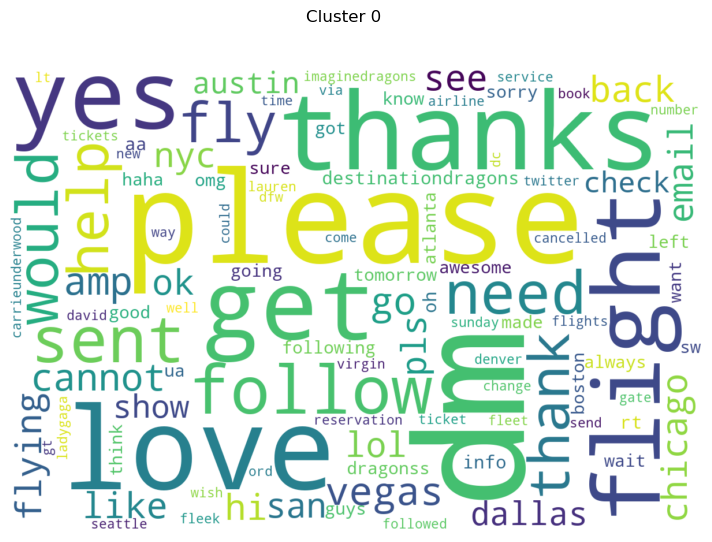

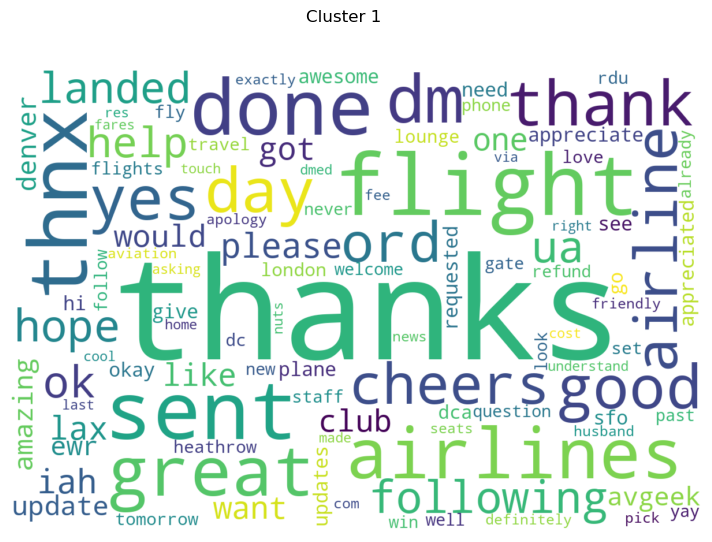

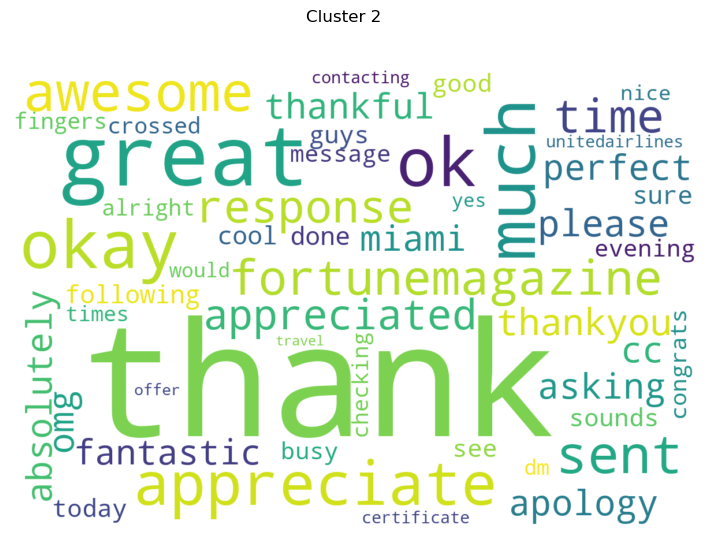

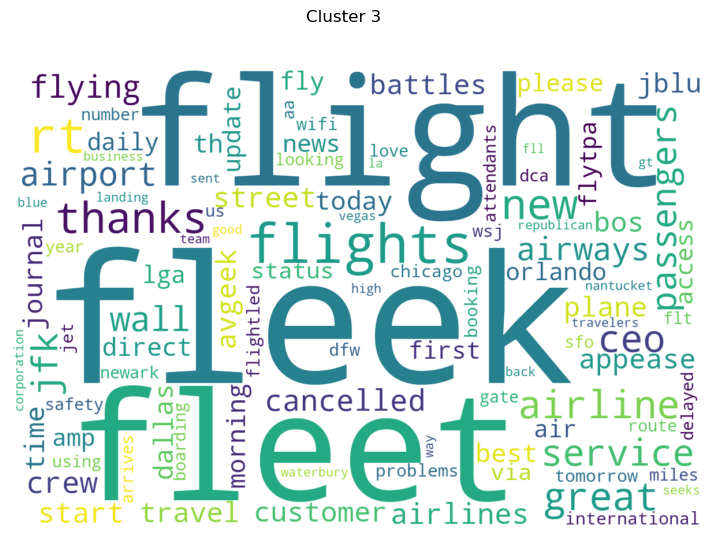

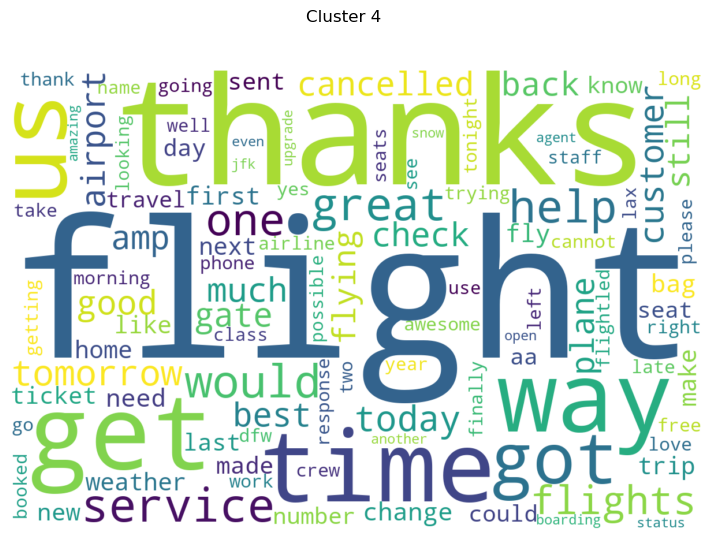

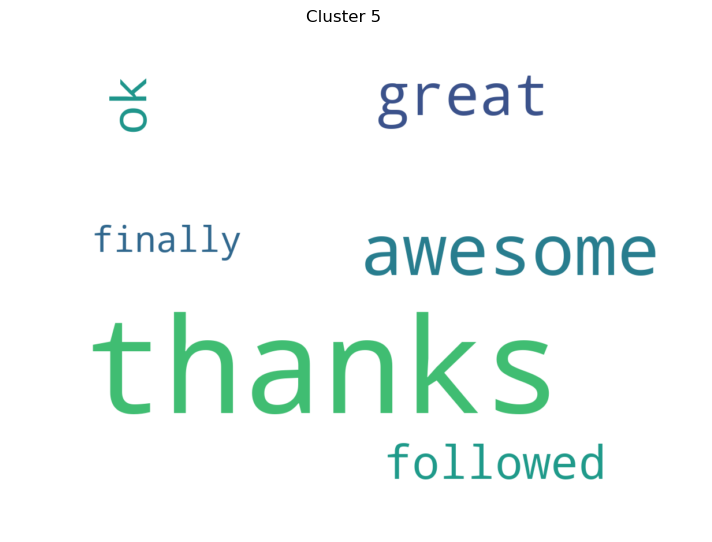

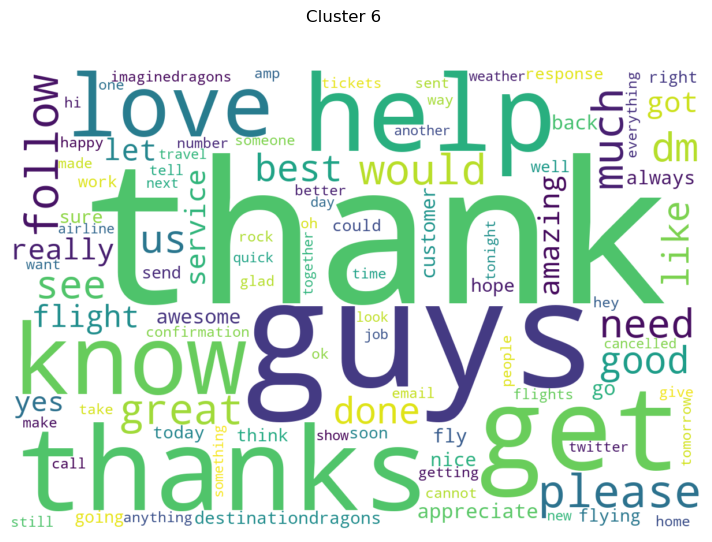

In [177]:
out_filename = '../figures/wordcloud_model={}_k={}_n_components={}.png'.format(
                                                                        modelname,
                                                                        kmeans.n_clusters,
                                                                        X_w2v.shape[1]
                                                                        )

generate_wordclouds(freqs, out_filename)

In [178]:
k = 8
modelname = 'kmeans_w2v'

kmeans = KMeans(n_clusters=k, max_iter=300, random_state=5)
y_pred, centroid = cluster_and_score(X_w2v, k, kmeans)
freqs = generate_word_frequencies_tfidf(y_pred, X_tfidf, word_positions)

print_top_terms(freqs, 10)

For n_clusters = 8 The average silhouette_score is : 0.038263159080507356
Silhouette values:
    Cluster 1: Size:64 | Avg:0.48 | Min:-0.00 | Max: 0.71
    Cluster 5: Size:141 | Avg:0.25 | Min:-0.08 | Max: 0.51
    Cluster 0: Size:1971 | Avg:0.06 | Min:0.01 | Max: 0.13
    Cluster 3: Size:1097 | Avg:0.03 | Min:-0.03 | Max: 0.13
    Cluster 6: Size:830 | Avg:0.01 | Min:-0.07 | Max: 0.14
    Cluster 7: Size:689 | Avg:0.01 | Min:-0.05 | Max: 0.14
    Cluster 2: Size:202 | Avg:-0.02 | Min:-0.20 | Max: 0.21
    Cluster 4: Size:468 | Avg:-0.05 | Min:-0.17 | Max: 0.11
Cluster 0: thanks flight service get way us customer help would time 
Cluster 1: thanks awesome great ok followed finally end empty employees employee 
Cluster 2: thanks dm flight sent thnx done airlines great thank day 
Cluster 3: thank guys thanks much great know get help love us 
Cluster 4: fleek fleet rt ceo flight new wall thanks passengers flights 
Cluster 5: thank great ok much okay appreciate awesome sent fortunemagazine 

In [180]:
k = 10
modelname = 'kmeans_w2v'

kmeans = KMeans(n_clusters=k, max_iter=300, random_state=5)
y_pred, centroid = cluster_and_score(X_w2v, k, kmeans)
freqs = generate_word_frequencies_tfidf(y_pred, X_tfidf, word_positions)

print_top_terms(freqs, 10)

For n_clusters = 10 The average silhouette_score is : 0.03390354170080107
Silhouette values:
    Cluster 2: Size:64 | Avg:0.47 | Min:-0.02 | Max: 0.71
    Cluster 9: Size:13 | Avg:0.45 | Min:-0.03 | Max: 0.67
    Cluster 1: Size:139 | Avg:0.25 | Min:-0.07 | Max: 0.51
    Cluster 4: Size:212 | Avg:0.07 | Min:-0.10 | Max: 0.27
    Cluster 3: Size:1238 | Avg:0.06 | Min:0.01 | Max: 0.16
    Cluster 6: Size:1763 | Avg:0.03 | Min:-0.02 | Max: 0.11
    Cluster 8: Size:1004 | Avg:0.01 | Min:-0.05 | Max: 0.14
    Cluster 0: Size:189 | Avg:-0.02 | Min:-0.20 | Max: 0.20
    Cluster 5: Size:597 | Avg:-0.03 | Min:-0.10 | Max: 0.12
    Cluster 7: Size:243 | Avg:-0.14 | Min:-0.28 | Max: 0.01
Cluster 0: thanks sent flight thnx done airlines great thank day yes 
Cluster 1: thank great ok much okay appreciate awesome sent fortunemagazine time 
Cluster 2: thanks awesome great ok followed finally end empty employees employee 
Cluster 3: flight get thanks would amp need help fly see please 
Cluster 4: flee

### sense2vec / spaCY

In [179]:
#!pip install sense2vec

In [103]:
import spacy
from spacy import displacy
from spacy.util import minibatch, compounding

import sense2vec
from sense2vec import Sense2VecComponent

In [104]:
data_path = "../data/"

intent = pd.read_csv(data_path + "intent_Tweets.csv", index_col=0)

In [105]:
nlp = spacy.load("en_core_web_sm")
s2v = nlp.add_pipe("sense2vec")
s2v.from_disk(data_path + "s2v_reddit_2015_md")

In [ ]:
nlp(intent.text[0])

In [172]:
most_similar,freq

([(('agressive', 'ADJ'), 0.9016),
  (('aggresive', 'ADJ'), 0.8805),
  (('aggressively', 'ADV'), 0.8017)],
 114729)

In [193]:
# generate averaged sense2vec embeddings
# break up lines of the corpus into words
def generate_avg_s2v(tweets):
    
    nlp_embedding_size = 128
    encodings = np.empty([len(tweets), nlp_embedding_size])
    
    i = 0
    for _,line in tweets.items():
        if isinstance(line, str):
            
            doc = nlp(line)
            vectors = [word._.s2v_vec for word in doc if not word._.s2v_vec is None]
            vectors = np.asarray(vectors)
            avg_sentence = np.average(np.asarray(vectors), axis=0)
            if np.isnan(avg_sentence).any():
                avg_sentence = np.zeros(nlp_embedding_size)
            encodings[i] = avg_sentence
            i+=1
    return encodings

In [194]:
X_s2v = generate_avg_s2v(intent_no_preproc.text)

/opt/anaconda3/envs/cs544/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/opt/anaconda3/envs/cs544/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


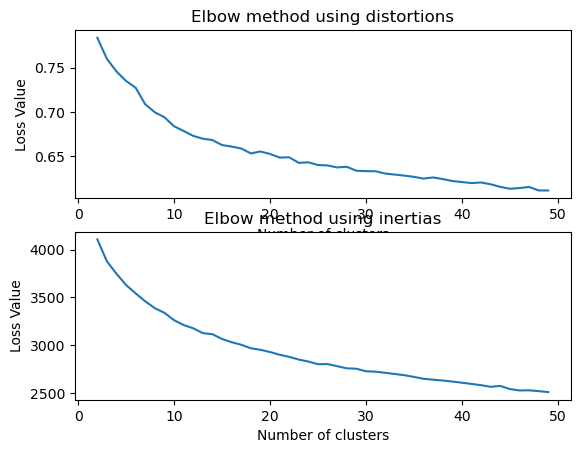

In [195]:
findK(X_s2v, max_k=50)

In [196]:
k = 4
modelname = 'kmeans_sense2vec'

kmeans = KMeans(n_clusters=k, max_iter=300, random_state=5)
y_pred, centroid = cluster_and_score(X_s2v, k, kmeans)
freqs = generate_word_frequencies_tfidf(y_pred, X_tfidf, word_positions)

print_top_terms(freqs, 10)

For n_clusters = 4 The average silhouette_score is : 0.05549154694537741
Silhouette values:
    Cluster 1: Size:167 | Avg:0.58 | Min:0.08 | Max: 0.64
    Cluster 0: Size:1746 | Avg:0.07 | Min:0.01 | Max: 0.19
    Cluster 3: Size:2881 | Avg:0.04 | Min:-0.03 | Max: 0.13
    Cluster 2: Size:668 | Avg:-0.03 | Min:-0.16 | Max: 0.16
Cluster 0: flight flights cancelled get tomorrow airline flying fly airport plane 
Cluster 1: thank thanks awesome ok cool appreciate would res jb okay 
Cluster 2: thanks thank dm sent please much great help appreciate follow 
Cluster 3: fleek fleet thanks get love would great thank help us 


In [197]:
k = 6
modelname = 'kmeans_sense2vec'

kmeans = KMeans(n_clusters=k, max_iter=300, random_state=5)
y_pred, centroid = cluster_and_score(X_s2v, k, kmeans)
freqs = generate_word_frequencies_tfidf(y_pred, X_tfidf, word_positions)

print_top_terms(freqs, 10)

For n_clusters = 6 The average silhouette_score is : 0.06530050475682478
Silhouette values:
    Cluster 4: Size:159 | Avg:0.59 | Min:0.04 | Max: 0.63
    Cluster 1: Size:2702 | Avg:0.07 | Min:0.01 | Max: 0.18
    Cluster 2: Size:457 | Avg:0.05 | Min:-0.12 | Max: 0.25
    Cluster 5: Size:1645 | Avg:0.04 | Min:-0.02 | Max: 0.18
    Cluster 0: Size:288 | Avg:-0.04 | Min:-0.19 | Max: 0.16
    Cluster 3: Size:211 | Avg:-0.06 | Min:-0.29 | Max: 0.09
Cluster 0: dm please sent follow email thanks send help confirmation yes 
Cluster 1: thanks get would thank great love help service flight us 
Cluster 2: thanks thank much great awesome help response appreciate guys got 
Cluster 3: fleek fleet rt love dmed lol ord dragonss lmao dm 
Cluster 4: thank thanks ok cool appreciate res jb okay cc perfect 
Cluster 5: flight flights cancelled get tomorrow airline fly flying airport plane 
